The following script is built to synchronize footage from two cameras that also record audio with another separate microphone. In total there are three audio streams and two video streams. The goal is to synchronize the two video streams with each other and then synchronize the audio from the two video streams with the separate audio stream. 

In [27]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
import sounddevice as sd
from pydub import AudioSegment
from moviepy.editor import VideoFileClip
import numpy as np
from pathlib import Path
import librosa
from scipy.signal import correlate, resample
import librosa
import os
from tqdm import tqdm
from IPython.display import Audio, Video
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import subprocess
import time
from glob import glob
%matplotlib inline

In [2]:
sessionpath = Path('/Users/f004swn/Documents/SCRAP/data/group_tests/session2')
cam1_vid = sessionpath / 'cam1' / 'concatenated' / 'cam1_concatenated.mp4'
cam2_vid = sessionpath / 'cam2' / 'concatenated' / 'cam2_concatenated.mp4'
audiomix = sessionpath / 'audio' / 'mixed' / 'audio_mixed.wav'
audiomix, mix_sr = librosa.load(audiomix, sr=None)

derivative_path = sessionpath / 'derivates'
os.makedirs(str(derivative_path), exist_ok=True)

In [3]:
# extract audio from video files
def extract_audio(posix_video_path):
    print("Extracting audio from video files...\n")
    out_audio_path = str(derivative_path / str(os.path.basename(str(posix_video_path)[:-4]+'.wav')))
    ffmpeg_extract_audio(str(posix_video_path), out_audio_path)
    # librosa returns the numpy array as well as the sample rate
    return librosa.load(out_audio_path, sr=None)


In [4]:
def mix_audio(list_of_arrays):
    """
    Takes a list of numpy arrays and mixes them together, padding the shorter arrays with zeros.
    """
    # find the longest array
    max_len = max([len(arr) for arr in list_of_arrays])
    # pad the shorter arrays with zeros
    padded_arrays = [np.pad(arr, (0, max_len-len(arr)), 'constant') for arr in list_of_arrays]
    # sum the arrays
    return np.sum(padded_arrays, axis=0)


In [5]:
def window_rms(a, rate=44100, window_ms=100):
    """
    Takes a numpy array representing audio and returns rolling-window root-mean-squared value.
    """
    window_size = int(round((rate/1000)*window_ms))
    ashape = a.shape[0]
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    rms_out = np.sqrt(np.convolve(a2, window, 'same'))
    rms_out = resample(rms_out, ashape)
    return  rms_out

In [6]:
def plot_rms(rms_array, maxlen):
    plt.figure(figsize=(20,5))
    plt.plot(rms_array)
    plt.xlim(0, maxlen)
    plt.show()

In [7]:
video_files = [cam1_vid, cam2_vid]
audio_files = [extract_audio(vid) for vid in tqdm(video_files)]

  0%|          | 0/2 [00:00<?, ?it/s]

Extracting audio from video files...

Moviepy - Running:
>>> "+ " ".join(cmd)


  0%|          | 0/2 [00:26<?, ?it/s]

Moviepy - Command successful


 50%|█████     | 1/2 [00:28<00:28, 28.07s/it]

Extracting audio from video files...

Moviepy - Running:
>>> "+ " ".join(cmd)


 50%|█████     | 1/2 [00:33<00:28, 28.07s/it]

Moviepy - Command successful


100%|██████████| 2/2 [00:34<00:00, 17.47s/it]


In [8]:
# Unpack the audio files
audio1, sr1 = audio_files[0]
audio2, sr2 = audio_files[1]

In [9]:
# resample mix to match the sample rate of the audio files extracted from the GoPros
# audiomix = librosa.resample(audiomix, orig_sr=mix_sr,  target_sr=sr1)

In [12]:
def plot_all(list_of_arrays):
    maxlen = max([i.shape[0] for i in list_of_arrays])
    n_arrays = len(list_of_arrays)
    fig, axs = plt.subplots(n_arrays, figsize=(20,5*n_arrays))
    for a, arr in enumerate(list_of_arrays):
        axs[a].plot(arr)
        axs[a].set_xlim(0, maxlen)
#plot_all([audio1, audio2, audiomix])

In [47]:
# Cross-correlate each audio stream with the mix
# The output array represents how similar the two signals are at each time step
# Here, the audio files are different lengths, so the output array is longer than either of the input arrays
# To address this, I'm going to pad the shorter audio file with zeros

# correlation1 = correlate(audio1, audiomix, mode='full')
# correlation2 = correlate(audio2, audiomix, mode='full')
# 
# cam1_frameshift = np.argmax(correlation1)
# cam2_frameshift = np.argmax(correlation2)
# print(cam1_frameshift / 44100)
# print(cam2_frameshift / 44100)

1223.9740362811792
1209.514195011338


In [ ]:
# Cross-correlate each audio stream with the mix
# The output array represents how similar the two signals are at each time step
# Here, the audio files are different lengths, so the output array is longer than either of the input arrays
# To address this, I'm going to pad the shorter audio file with zeros

# corr = correlate(audio1, audio2, mode='full')

In [59]:
# shift = np.argmax(corr) - len(audio1)
# ad2_shifted = np.roll(audio2, shift)
# #plot_all([audio1, np.roll(audio2, shift)])
# aamix = mix_audio([audio1, ad2_shifted])

In [14]:
def align_audio(list_of_camera_audio_arrays, microphone_mix, chop_to_shortest=False):
    """
    Takes a list of numpy arrays representing audio from each camera and a numpy array representing the microphone mix.
    Returns a list of numpy arrays representing the aligned audio from each camera.
    """
    # cross-correlate each audio stream with the mix
    # the output array represents how similar the two signals are at each time step
    all_arrays = list_of_camera_audio_arrays + [microphone_mix]
    # find the longest array
    max_pos = np.argmax(np.array([len(arr) for arr in all_arrays]))
    maxlen = len(all_arrays[max_pos])
    del all_arrays
    # pad the shorter arrays with zeros    
    list_of_camera_audio_arrays = [np.pad(arr, (0, maxlen-len(arr)), 'constant') for arr in list_of_camera_audio_arrays]
    microphone_mix = np.pad(microphone_mix, (0, maxlen-len(microphone_mix)), 'constant')
    # cross-correlate each array with the microphone mix
    print("Cross-correlating audio streams with microphone mix...\n")
    correlations = [correlate(arr, microphone_mix, mode='full') for arr in list_of_camera_audio_arrays]
    # find the time shift (in seconds) that maximizes the correlation
    print("Finding time shift that maximizes correlation...\n")
    shifts = [np.argmax(corr) - len(arr) for corr, arr in zip(correlations, list_of_camera_audio_arrays)]
    for s, shift in enumerate(shifts):
        print(f'Shift {s}: {shift} samples')
    # shift the audio streams
    print("Shifting audio streams...\n")
    # if microphone_is_longest:
    #     shifted_audio = [np.roll(arr, -shift) for arr, shift in zip(list_of_camera_audio_arrays, shifts)]
    # else:
    #     shifted_audio = [np.roll(arr, shift) for arr, shift in zip(list_of_camera_audio_arrays, shifts)]
    shifted_audio = [np.roll(arr, -shift) for arr, shift in zip(list_of_camera_audio_arrays, shifts)]
    
    return shifted_audio + [microphone_mix]

In [16]:
def get_shift_values(list_of_camera_audio_arrays, microphone_mix, chop_to_shortest=False):
    """
    Takes a list of numpy arrays representing audio from each camera and a numpy array representing the microphone mix.
    Returns a list of numpy arrays representing the aligned audio from each camera.
    """
    # cross-correlate each audio stream with the mix
    # the output array represents how similar the two signals are at each time step
    all_arrays = list_of_camera_audio_arrays + [microphone_mix]
    # find the longest array
    max_pos = np.argmax(np.array([len(arr) for arr in all_arrays]))
    maxlen = len(all_arrays[max_pos])
    del all_arrays
    # pad the shorter arrays with zeros    
    list_of_camera_audio_arrays = [np.pad(arr, (0, maxlen-len(arr)), 'constant') for arr in list_of_camera_audio_arrays]
    microphone_mix = np.pad(microphone_mix, (0, maxlen-len(microphone_mix)), 'constant')
    # cross-correlate each array with the microphone mix
    print("Cross-correlating audio streams with microphone mix...\n")
    correlations = [correlate(arr, microphone_mix, mode='full') for arr in list_of_camera_audio_arrays]
    # find the time shift (in seconds) that maximizes the correlation
    print("Finding time shift that maximizes correlation...\n")
    shifts = [np.argmax(corr) - len(arr) for corr, arr in zip(correlations, list_of_camera_audio_arrays)]
    for s, shift in enumerate(shifts):
        print(f'Shift {s}: {shift} samples')
    return shifts

Cross-correlating audio streams with microphone mix...
Finding time shift that maximizes correlation...

Shift 0: 3262608 samples
Shift 1: -21071 samples
Shifting audio streams...


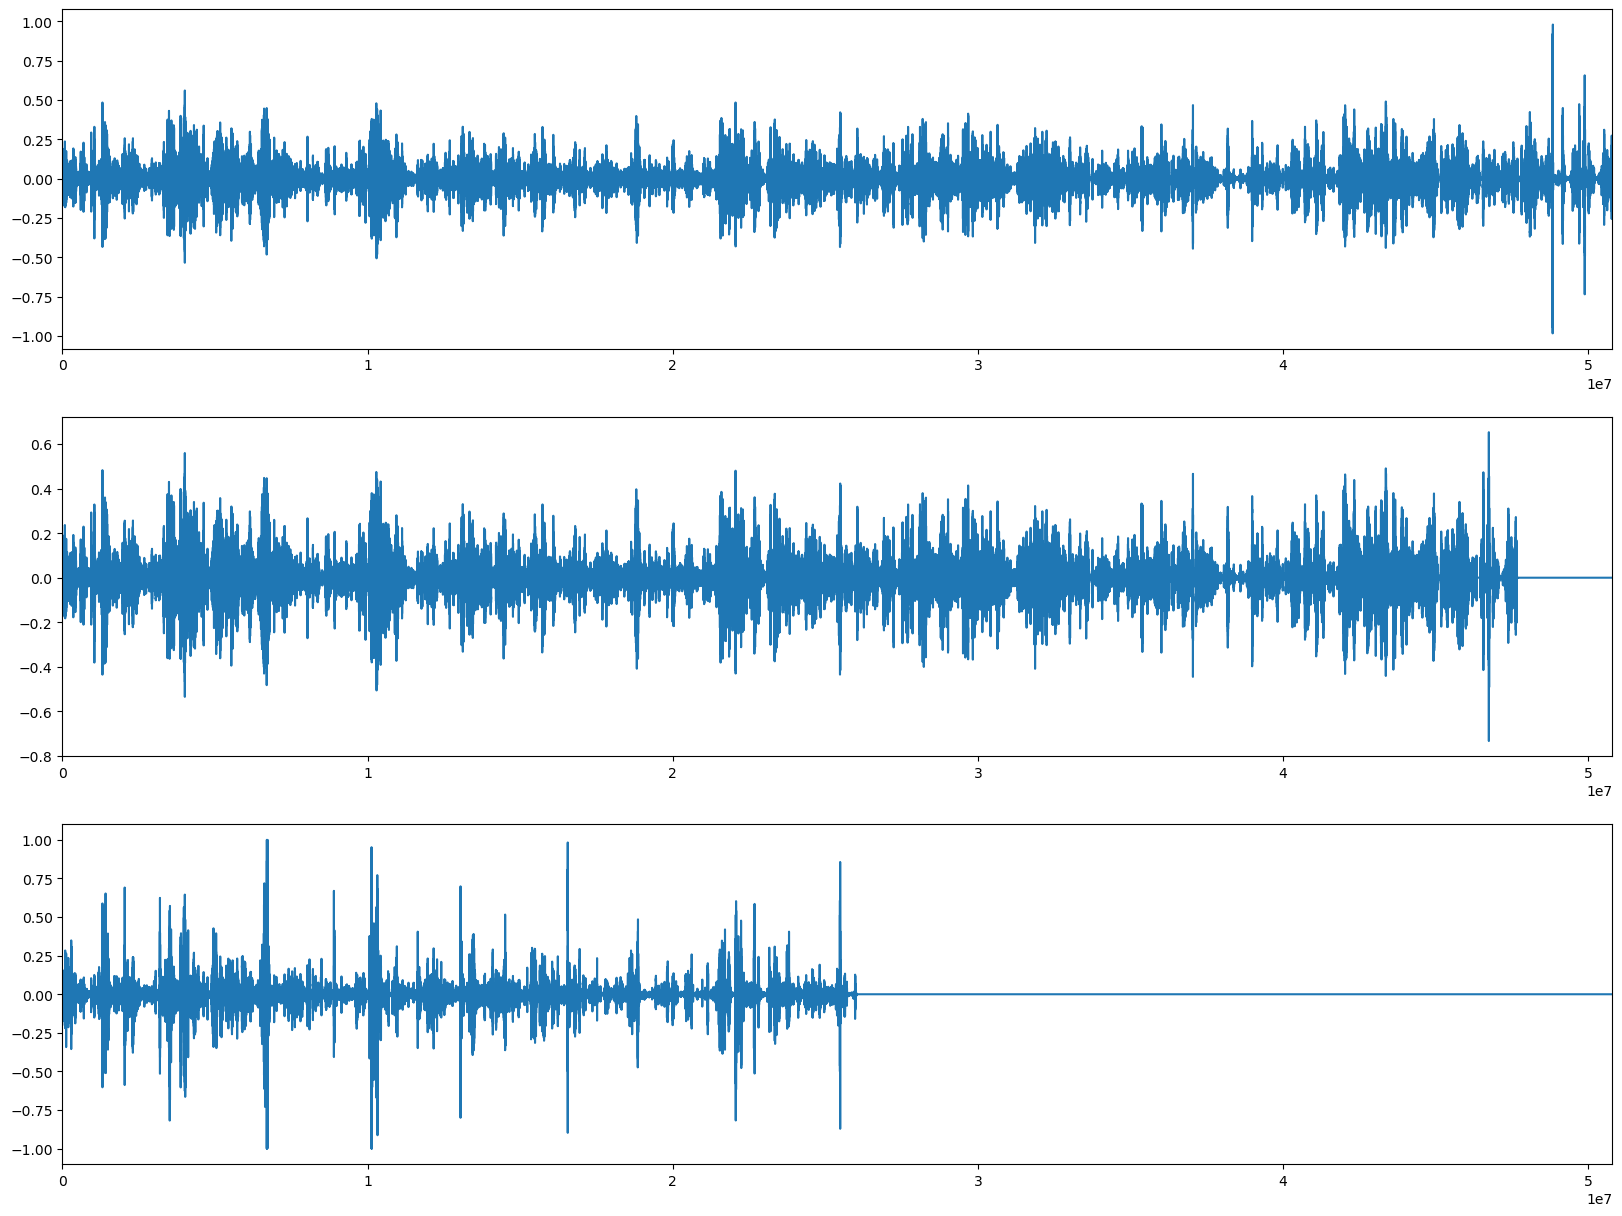

In [15]:
# creating artificial roll to check robustness of algorithm
audio1_roll_30 = np.roll(audio1, 44100*30)
audio2_roll_neg_30 = np.roll(audio2, -44100*30)
# create extra short audio mix
audiomix_short = audiomix[:int(len(audiomix)/2)]
test_output = align_audio([audio1_roll_30, audio2_roll_neg_30], audiomix_short)
plot_all(test_output)
sd.play(mix_audio(test_output), sr1)
time.sleep(5)
sd.stop()

Cross-correlating audio streams with microphone mix...
Finding time shift that maximizes correlation...

Shifting audio streams...


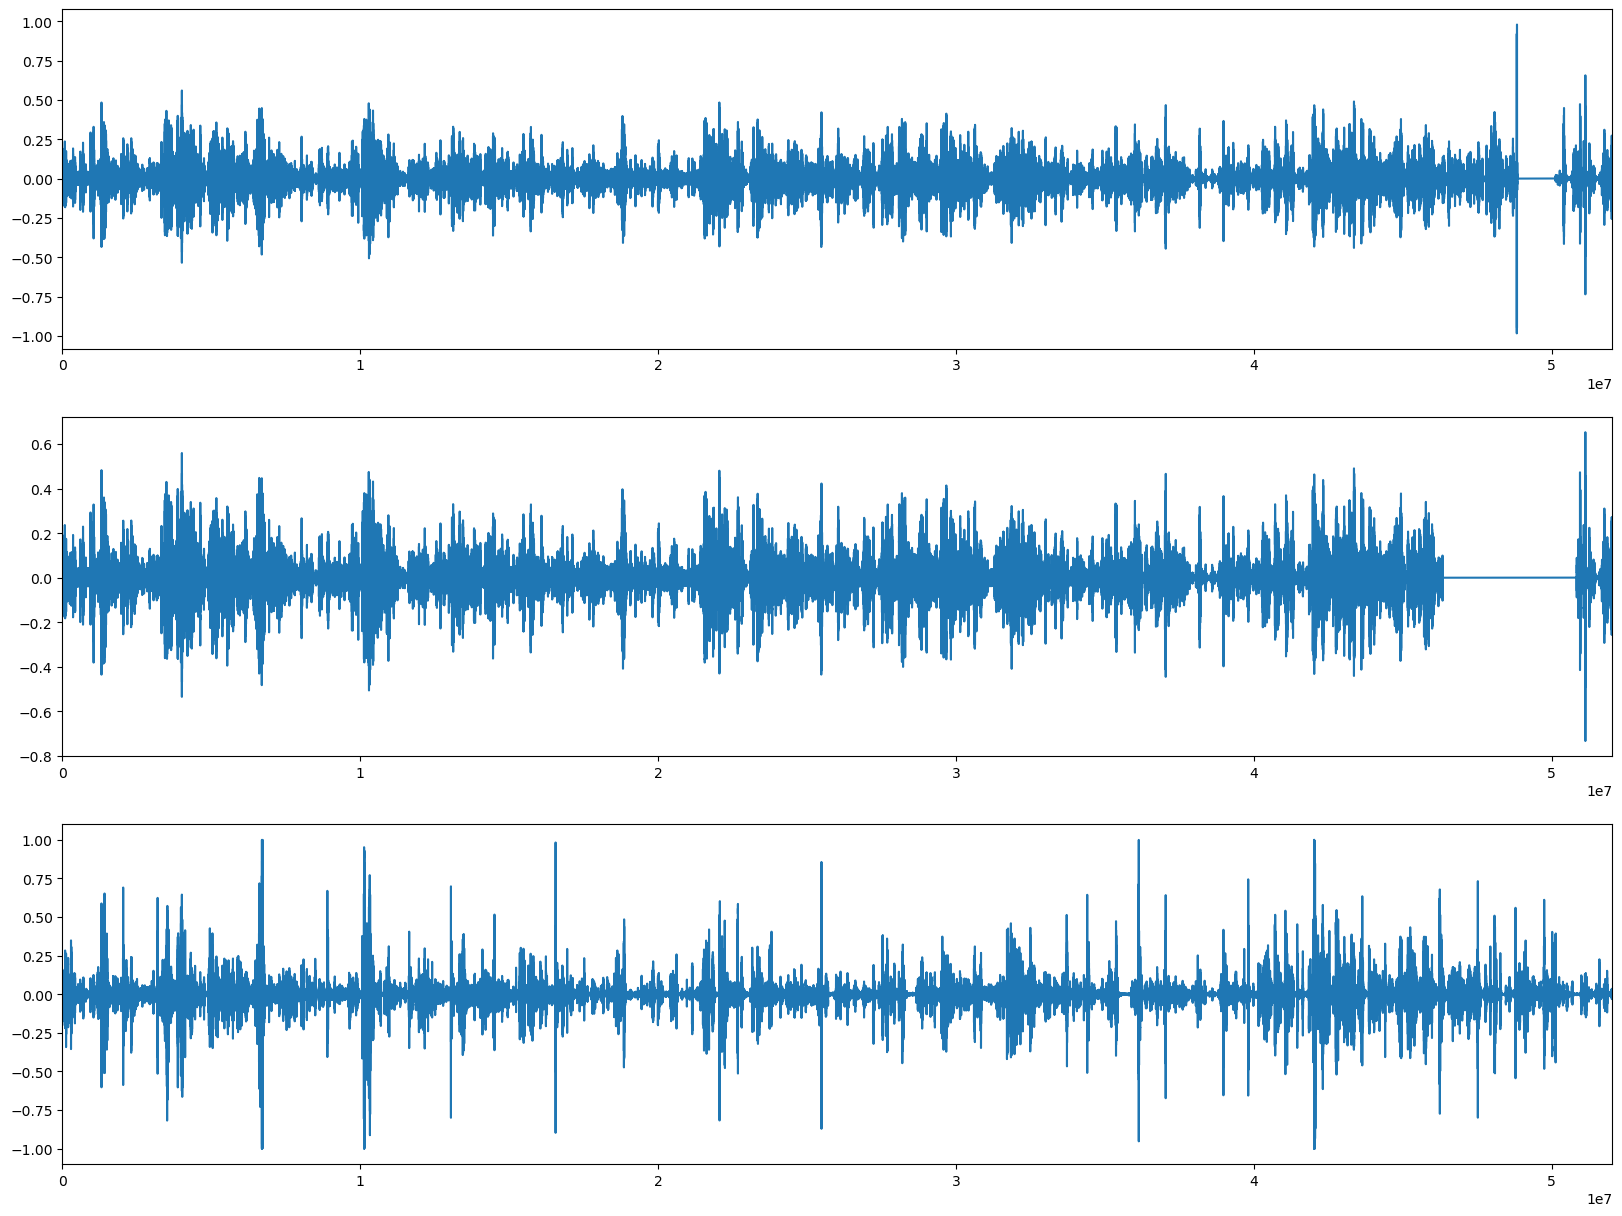

In [53]:
output = align_audio([audio1, audio2], audiomix)
plot_all(output)

sd.play(mix_audio(output), sr1)
time.sleep(5)
sd.stop()

In [17]:
all_aligned = align_audio([audio1, audio2], audiomix)

Cross-correlating audio streams with microphone mix...
Finding time shift that maximizes correlation...

Shifting audio streams...


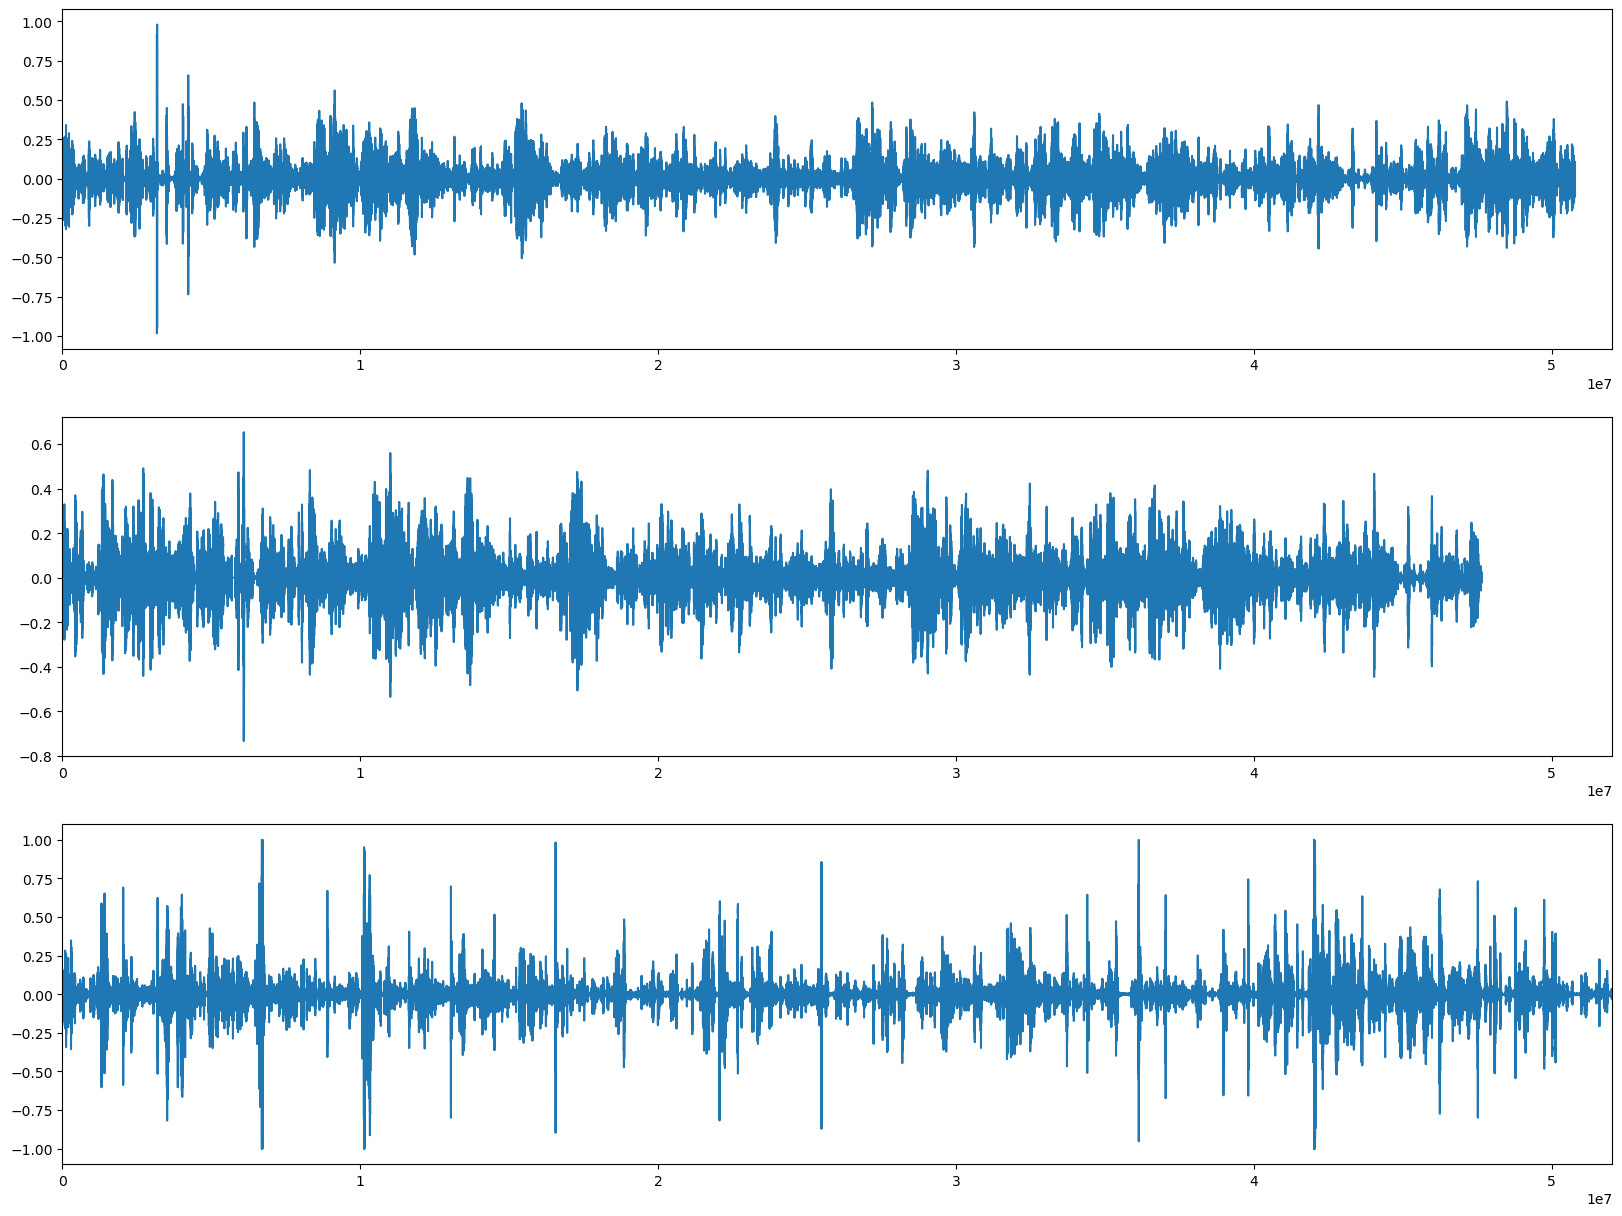

In [18]:
# plot the aligned audio
plot_all(all_aligned)

I want to chop off either the ending or the beginning of the two clips (audio *or* video) that are longer than the shortest clip

In [17]:
shift_values = get_shift_values([audio1, audio2], audiomix)
print(shift_values)

Cross-correlating audio streams with microphone mix...
Finding time shift that maximizes correlation...

Shift 0: 1939608 samples
Shift 1: 1301929 samples
[1939608, 1301929]


In [55]:
def trim_video(posix_video_path, start_time, end_time, output_path):
    """
    Takes a posix path to a video file, a start trim value (in seconds), an end trim value (in seconds), and an output path.
    Trims the video and saves it to the output path.
    """
    stringPath = str(posix_video_path)
    duration = VideoFileClip(stringPath).duration
    ffmpeg_command = f'ffmpeg -i {stringPath} -ss {start_time} -to {duration-end_time} -c copy {output_path}'
    subprocess.run(ffmpeg_command, shell=True)

In [56]:
def trim_audio(posix_audio_path, start_time, end_time, output_path):
    """
    Takes a posix path to an audio file, a start trim value (in seconds), an end trim value (in seconds), and an output path.
    Trims the audio and saves it to the output path.
    """
    stringPath = str(posix_audio_path)
    duration = librosa.get_duration(filename=stringPath)
    ffmpeg_command = f'ffmpeg -i {stringPath} -ss {start_time} -to {duration-end_time} -c copy {output_path}'
    subprocess.run(ffmpeg_command, shell=True)

In [25]:
trim_video(cam1_vid, beginning_trim, 3*60, str(derivative_path / 'cam1_trimmed_10_180.mp4'))

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/f004swn/anaconda3/envs/multidata --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, mov,mp4,m4a,

In [57]:
def align_data(list_of_video_paths, list_of_mic_paths):
    # make mix of all mics
    print("Mixing microphone audio...\n")
    mic_mix = mix_audio([librosa.load(mic, sr=None)[0] for mic in list_of_mic_paths])
    mic_audio_sr = librosa.load(list_of_mic_paths[0], sr=None)[1]
    
    # extract audio from video files
    print("Extracting audio from video files...\n")
    video_audio = [extract_audio(vid) for vid in list_of_video_paths]
    video_audio_sr = video_audio[0][1]
    video_audio = [i[0] for i in video_audio]
    
    assert mic_audio_sr == video_audio_sr, "Sample rates of audio files do not match."
    
    # get durations of video files
    print("Getting durations of video files...\n")
    video_durations = dict(zip(list_of_video_paths, [VideoFileClip(str(vid)).duration for vid in list_of_video_paths]))
    audio_duration = mic_mix.shape[0]/mic_audio_sr
    
    # get shift values
    print("Getting shift values...\n")
    shift_values = get_shift_values(video_audio, mic_mix)
    
    # check distribution of positive and negative shifts
    if all([shift > 0 for shift in shift_values]):
        trim_status = 'early'
    elif all([shift < 0 for shift in shift_values]):
        trim_status = 'late'
    else:
        trim_status = 'mixed'
    
    start_end_keys = dict(zip(['beginning_trim', 'ending_time'], [[], []]))
    all_files = list_of_video_paths + ['audio_trim']
    trim_times = dict(zip(all_files, [start_end_keys for i in range(len(all_files))]))
        
    if trim_status == 'early':
        # trim the beginning of the video files
        for vid, shift in zip(list_of_video_paths, shift_values):
            trim_amount = shift/sr1
            trim_times[vid]['beginning_trim'] = trim_amount
            video_durations[vid] = video_durations[vid] - trim_amount
            
        trim_times['audio_trim']['beginning_trim'] = 0
        
    elif trim_status == 'late':
        # trim the end of the video files
        latest = min(shift_values)
        
        for vid, shift in zip(list_of_video_paths, shift_values):
            if shift == latest:
                trim_times[vid]['beginning_trim'] = 0
            else:
                trim_amount = (abs(latest) - abs(shift))/video_audio_sr
                trim_times[vid]['beginning_trim'] = trim_amount
                video_durations[vid] = video_durations[vid] - trim_amount
        
        audio_trim = abs(latest)/mic_audio_sr
        trim_times['audio_trim']['beginning_trim'] = audio_trim
        audio_duration = audio_duration - audio_trim
        
    elif trim_status == 'mixed':
        latest = min(shift_values)
        earliest = max(shift_values)
        for vid, shift in zip(list_of_video_paths, shift_values):
            if shift == latest:
                trim_times[vid]['beginning_trim'] = 0
            elif shift > 0:
                trim_amount = (abs(shift)+abs(latest))/video_audio_sr
                trim_times[vid]['beginning_trim'] = trim_amount
                video_durations[vid] = video_durations[vid] - trim_amount
            else:
                trim_amount = (abs(latest) - abs(shift))/video_audio_sr
                trim_times[vid]['beginning_trim'] = trim_amount
                video_durations[vid] = video_durations[vid] - trim_amount
        
        audio_trim = abs(latest)/mic_audio_sr
        trim_times['audio_trim']['beginning_trim'] = audio_trim
        audio_duration = audio_duration - audio_trim
    
    # get ending trim times
    print(type(video_durations.values()))
    all_durations = list(video_durations.values()) + [audio_duration]
    print(all_durations)
    
    shortest = min(all_durations)
    for file in trim_times.keys():
        trim_times[file]['ending_time'] = shortest
        
    # trim the video files
    print("Trimming video files...\n")
    for vid in list_of_video_paths:
        trim_video(vid, trim_times[vid]['beginning_trim'], trim_times[vid]['ending_time'], str(derivative_path / f'{os.path.basename(str(vid))[:-4]}_trimmed.mp4'))
        
    # trim the audio files
    print("Trimming audio files...\n")
    for mic in list_of_mic_paths:
        trim_audio(mic, trim_times['audio_trim']['beginning_trim'], trim_times['audio_trim']['ending_time'], str(derivative_path / f'{os.path.basename(str(mic))[:-4]}_trimmed.wav'))

In [58]:
mic_files = glob(str(sessionpath / 'audio' / 'TRACK*.WAV'))
video_files = glob(str(sessionpath / 'cam*' / 'concatenated' / '*.mp4'))

In [52]:
align_data(video_files, mic_files)

Mixing microphone audio...
Extracting audio from video files...

Extracting audio from video files...

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Extracting audio from video files...

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Getting durations of video files...
Getting shift values...
Cross-correlating audio streams with microphone mix...
Finding time shift that maximizes correlation...

Shift 0: 1301929 samples
Shift 1: 1939608 samples
<class 'dict_values'>
[1050.8878004535147, 1107.6279591836733, 1179.9916553287983]
Trimming video files...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/f004swn/anaconda3/envs/multidata --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, mov,mp4,m4a,

Trimming audio files...


NameError: name 'trim_audio' is not defined